### KNN implementation

In [32]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

class OurKNearestNeighbors():
    """ K-nearest neighbors model using numpy"""

    def __init__(self, n_neighbors=2):
        """
        Model constructor
        Inputs:
        n_neighbors -> the amount of neighbors to consider in the model
        """
        self.X_train = 0.0
        self.y_train = 0.0

        self.n_neighbors = n_neighbors

    def get_params(self, deep=True):
        """
        Get the model hyperparameters
        """
        return {'n_neighbors': self.n_neighbors}

    def set_params(self, **parameters):
        """
        Set the model hyperparameters
        """
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def minkowski_distance(self, a, b, p=10):
        return np.power(np.sum(np.power(np.abs(a - b), p), axis=1), 1/p)

    def kneighbors(self, X_test):
        """
        get the closest data from a test dataset
        """
        dist = []
        neigh_ind = []
        point_dist = []

        for x_test in X_test:
            point_dist += [ self.minkowski_distance(x_test, self.X_train) ]

        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh,
                                  key=lambda x: x[1])[:self.n_neighbors]

            ind_list = [tup[0] for tup in sorted_neigh]
            dist_list = [tup[1] for tup in sorted_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        return np.array(neigh_ind)

    def predict(self, X_test):
        """
        Cathegorize the test dataset based nearest neighbors values
        """
        neighbors = self.kneighbors(X_test)
        y_pred = np.array([
            np.argmax(np.bincount(self.y_train[neighbor]))
            for neighbor in neighbors
        ])
        return y_pred

    def score(self, X_test, y_test):
        """
        Score the obtained values
        """
        y_pred = self.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        return accuracy

    # model metrics

    def accurancy(self, y_pred,y_test):
        return accuracy_score(y_test, y_pred)
    
    def precision(self, y_pred,y_test):
        return precision_score(y_test, y_pred)
    
    def recall(self, y_pred,y_test):
        return recall_score(y_test, y_pred)
        
    def auc(self, y_pred,y_test):
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc
    
    def plot_roc(self, fpr, tpr, title):
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Especificity')
        plt.ylabel('Sensibility')
        plt.title(title)
        plt.show()

### Red Wine Dataset

In [33]:
# read the data set
df_wine = pd.read_csv('datasets/winequality-red.csv')

# make sure that there are no null values that can affect the models
mask = df_wine.isnull()
#print(mask.sum())

# visualizing the values of each feature and the comparison to the output
# (not ploting to avoid data overload in the notebook)
"""
for col in df_wine.columns[:-1]:
    df_wine.plot(x=col, y='quality', kind='scatter', figsize=(8, 5))
plt.show()
"""

# Data preprocessing - outliner treatment
# eliminating data that is outside the normal values in each feature
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
l_limit_perc = 0.01
h_limit_perc = 0.99

for feature in features:
    low_limit = df_wine[feature].quantile(l_limit_perc)
    high_limit = df_wine[feature].quantile(h_limit_perc)
    df_wine = df_wine.loc[(df_wine[feature] >= low_limit) & (df_wine[feature] <= high_limit)]

# visualizing the new values
# (not ploting to avoid data overload in the notebook)
"""
for col in df_wine.columns[:-1]:
    df_wine.plot(x=col, y='quality', kind='scatter', figsize=(8, 5))
plt.show()
"""

# feature engineering
# normalization of the data
for feature in features:
    df_wine[feature] = (df_wine[feature]-df_wine[feature].mean())/df_wine[feature].std()

# change the value of the output to only two values
# 0 -> bad wine, wines with 3, 4 and 5 in quality
# 1 -> good wine, wines with 6, 7 and 8 in queality
df_wine.loc[df_wine['quality'] <= 5, 'quality'] = 0
df_wine.loc[df_wine['quality'] > 5, 'quality'] = 1

# Define training and test sets using stratify
X0 = df_wine.loc[df_wine['quality'] == 0, features]
Y0 = df_wine.loc[df_wine['quality'] == 0, 'quality']

X1 = df_wine.loc[df_wine['quality'] == 1, features]
Y1 = df_wine.loc[df_wine['quality'] == 1, 'quality']

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, Y0, test_size=0.4, random_state=40)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.4, random_state=40)

X_train = pd.concat([X0_train, X1_train], axis= 0)
y_train = pd.concat([y0_train, y1_train], axis= 0)

df_wine.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.565253,1.059618,-1.411229,-0.553438,-0.287522,-0.479510,-0.355404,0.672341,1.474535,-0.638760,-1.000675,0
1,-0.304938,2.161772,-1.411229,0.207560,0.571559,1.031186,0.767153,0.024570,-0.872713,0.332310,-0.574418,0
2,-0.304938,1.427003,-1.193394,-0.118582,0.337264,-0.047882,0.324934,0.154124,-0.418407,0.089543,-0.574418,0
3,1.907741,-1.512074,1.638460,-0.553438,-0.326572,0.167932,0.529035,0.801895,-1.175584,-0.476915,-0.574418,1
4,-0.565253,1.059618,-1.411229,-0.553438,-0.287522,-0.479510,-0.355404,0.672341,1.474535,-0.638760,-1.000675,0
5,-0.565253,0.814695,-1.411229,-0.662152,-0.326572,-0.263696,-0.151302,0.672341,1.474535,-0.638760,-1.000675,0
6,-0.239859,0.447311,-1.084476,-0.879580,-0.560867,-0.047882,0.495018,-0.234539,-0.115536,-1.447985,-1.000675,0
8,-0.304938,0.324849,-1.302311,-0.444724,-0.404670,-0.695323,-0.899674,0.024570,0.338770,-0.557837,-0.894111,1
9,-0.500174,-0.164997,0.549286,4.012548,-0.482768,0.167932,1.957744,0.672341,0.263052,1.303380,0.171531,0
10,-1.020805,0.324849,-0.975559,-0.662152,0.532510,-0.047882,0.699120,-0.558425,-0.266972,-0.800605,-1.213804,0


### Train model and test results

Best hyperparameters:  {'n_neighbors': 5}
    Amount of tests          Model  Accurancy  Precision    Recall       Auc
0                25      Our model   0.640000   0.629630  0.680000  0.640000
1                25  Sklearn model   0.640000   0.629630  0.680000  0.640000
2                63      Our model   0.650794   0.617284  0.793651  0.650794
3                63  Sklearn model   0.706349   0.671053  0.809524  0.706349
4               126      Our model   0.654762   0.622642  0.785714  0.654762
5               126  Sklearn model   0.690476   0.662162  0.777778  0.690476
6               189      Our model   0.640212   0.612766  0.761905  0.640212
7               189  Sklearn model   0.666667   0.643836  0.746032  0.666667
8               226      Our model   0.650442   0.622302  0.765487  0.650442
9               226  Sklearn model   0.665929   0.643678  0.743363  0.665929
10              252      Our model   0.660714   0.633663  0.761905  0.660714
11              252  Sklearn model

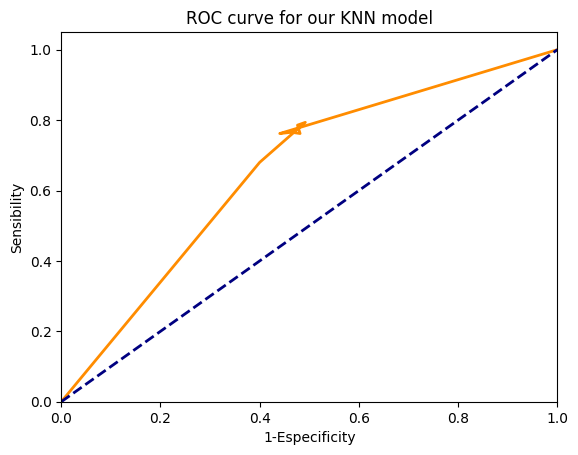

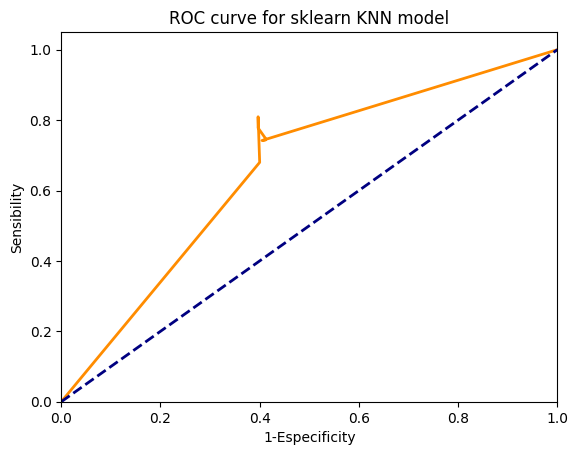

In [34]:
# initial variables
test_percentages = [0.1, 0.25, 0.50, 0.75, 0.9, 1]
y_tests = {'our_model': [], 'sklearn_model': []}
y_preds = {'our_model': [], 'sklearn_model': []}
accurancies = {'our_model': [], 'sklearn_model': []}
precisions = {'our_model': [], 'sklearn_model': []}
recalls = {'our_model': [], 'sklearn_model': []}
num_rows = min(X0_test.shape[0], X1_test.shape[0])

# Get the best model hyperparameters
model = OurKNearestNeighbors()
param_grid = {'n_neighbors': [5, 7, 9, 11]}
grid_search = GridSearchCV(model, param_grid, cv=5, error_score='raise')
grid_search.fit(X_train.values, y_train.values)

print("Best hyperparameters: ", grid_search.best_params_)

# Instantiate model with the best hyperparameters
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
k = 5
model = OurKNearestNeighbors(k)
model.fit(X_train, y_train)

model_sklearn = KNeighborsClassifier(n_neighbors=k)
model_sklearn.fit(X_train, y_train)

# get testing metrics by using different amount of tests
for test_percentage in test_percentages:

    # get the amount of data needed for each percentage
    n_tests = int(num_rows * test_percentage)
    X0_test_i = X0_test.iloc[:n_tests, :]
    X1_test_i = X1_test.iloc[:n_tests, :]
    y0_test_i = y0_test.iloc[:n_tests]
    y1_test_i = y1_test.iloc[:n_tests]

    X_test_i = pd.concat([X0_test_i, X1_test_i], axis= 0)
    y_test_i = pd.concat([y0_test_i, y1_test_i], axis= 0)
    y_tests['our_model'].append(y_test_i)
    y_tests['sklearn_model'].append(y_test_i)

    ## Predictions for out model
    # predict classes for test set
    if isinstance(X_test_i, pd.DataFrame):
        X_test_i = X_test_i.to_numpy()
        
    y_pred_i = model.predict(X_test_i)
    y_pred_i = pd.DataFrame(y_pred_i)

    y_preds['our_model'].append(y_pred_i)

    # get the metrics
    accurancies['our_model'].append(model.accurancy(y_pred_i, y_test_i))
    precisions['our_model'].append(model.precision(y_pred_i, y_test_i))
    recalls['our_model'].append(model.recall(y_pred_i, y_test_i))

    ## Predictions for sklearn model
    y_pred_i = model_sklearn.predict(X_test_i)
    y_preds['sklearn_model'].append(y_pred_i)

    # get the metrics
    accurancies['sklearn_model'].append(model.accurancy(y_pred_i, y_test_i))
    precisions['sklearn_model'].append(model.precision(y_pred_i, y_test_i))
    recalls['sklearn_model'].append(model.recall(y_pred_i, y_test_i))

# draw ROC curve
fpr_model = np.array([0., 1.])
tpr_model = np.array([0., 1.])
fpr_sk = np.array([0., 1.])
tpr_sk = np.array([0., 1.])
aucs = {'our_model': [], 'sklearn_model': []}
for i in range(len(test_percentages)):
    fpr_i, tpr_i, auc_i = model.auc(y_preds['sklearn_model'][i], y_tests['sklearn_model'][i])
    fpr_sk = np.insert(fpr_sk, -1, fpr_i[1])
    tpr_sk = np.insert(tpr_sk, -1, tpr_i[1])
    aucs['sklearn_model'].append(auc_i)

    fpr_i, tpr_i, auc_i = model.auc(y_preds['our_model'][i], y_tests['our_model'][i])
    fpr_model = np.insert(fpr_model, -1, fpr_i[1])
    tpr_model = np.insert(tpr_model, -1, tpr_i[1])
    aucs['our_model'].append(auc_i)

# display test metric results
title_row = ['Amount of tests','Model', 'Accurancy', 'Precision', 'Recall', 'Auc']
df_results = pd.DataFrame(columns=title_row)

for i, test_percentage in enumerate(test_percentages):
    row = [int(test_percentage*num_rows), 'Our model', accurancies['our_model'][i], precisions['our_model'][i], recalls['our_model'][i], aucs['our_model'][i]]
    df_results.loc[len(df_results)] = row
    row = [int(test_percentage*num_rows), 'Sklearn model', accurancies['sklearn_model'][i], precisions['sklearn_model'][i], recalls['sklearn_model'][i], aucs['sklearn_model'][i]]
    df_results.loc[len(df_results)] = row

print(df_results)
model.plot_roc(fpr_model, tpr_model, 'ROC curve for our KNN model')
model.plot_roc(fpr_sk, tpr_sk, 'ROC curve for sklearn KNN model')